In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler,RobustScaler
import scipy
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV
import warnings
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import matplotlib.style as style
warnings.filterwarnings('ignore')

In [2]:
train_csv = '/Users/minhopark/git-reposits/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
test_csv = '/Users/minhopark/git-reposits/kaggle/input/house-prices-advanced-regression-techniques/test.csv'

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)
print(f'The shape of train data is {df_train.shape}')
print(f'The shape of test data is {df_test.shape}')
df_train.head()

The shape of train data is (1460, 81)
The shape of test data is (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
def target_analysis(target):
    fig = plt.figure(constrained_layout=True, figsize=(14,10))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(target, norm_hist=True, ax=ax1)
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Q-Q Plot')
    stats.probplot(target, plot=ax2)
    ax3 = fig.add_subplot(grid[:,2])
    ax3.set_title('Box Plot')
    sns.boxplot(target, orient='v', ax=ax3)
    print("skewness is ",target.skew())
    plt.show()

skewness is  1.8828757597682129


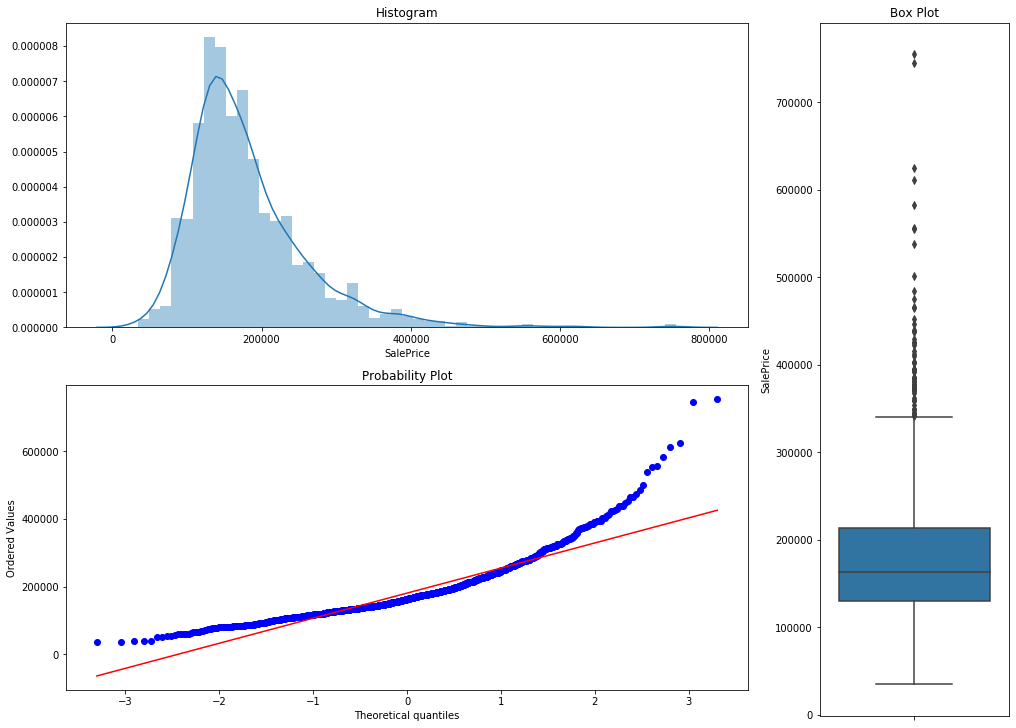

In [4]:
target_analysis(df_train['SalePrice'])

In [5]:
import numpy as np

skewness is  0.12134661989685329


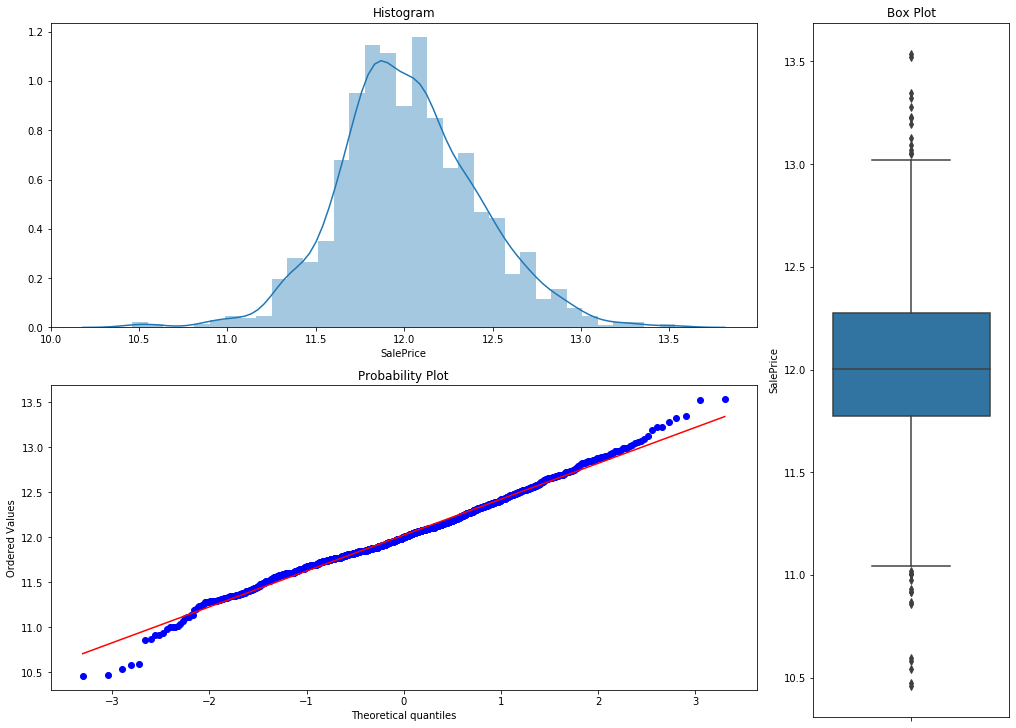

In [6]:
target_analysis(np.log1p(df_train['SalePrice']))

In [7]:
num_cols_tr = df_train.select_dtypes('number').columns.tolist()
num_cols_te = df_test.select_dtypes('number').columns.tolist()

print("There are %d numeric columns in train data"%len(num_cols_tr))
df_num = df_train[num_cols_tr]
df_test_num = df_test[num_cols_te]

print("Train/test numeric shapes")
print(df_num.shape)
print(df_test_num.shape)

There are 38 numeric columns in train data
Train/test numeric shapes
(1460, 38)
(1459, 37)


In [8]:
df_num.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [9]:
df_num = df_num.drop(columns=['Id'])
df_test_num = df_test_num.drop(columns=['Id'])

In [10]:
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [11]:
corr = df_num.corr()

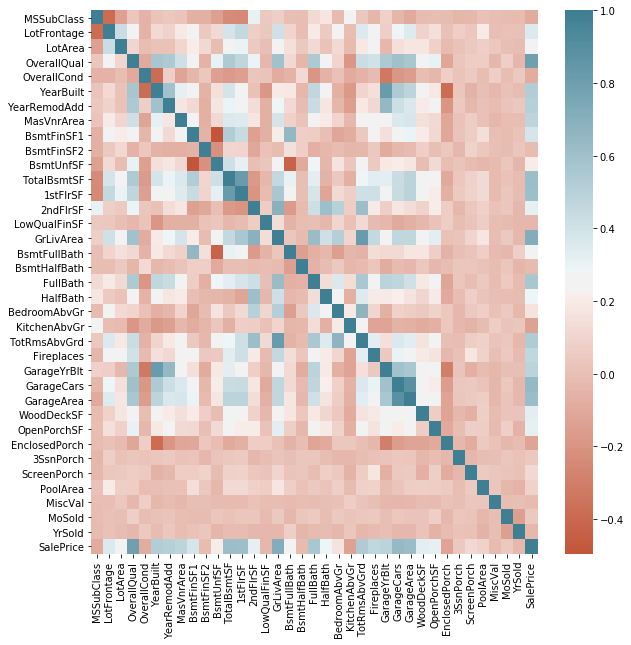

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

In [13]:
print(corr)

               MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
MSSubClass       1.000000    -0.386347 -0.139781     0.032628    -0.059316   
LotFrontage     -0.386347     1.000000  0.426095     0.251646    -0.059213   
LotArea         -0.139781     0.426095  1.000000     0.105806    -0.005636   
OverallQual      0.032628     0.251646  0.105806     1.000000    -0.091932   
OverallCond     -0.059316    -0.059213 -0.005636    -0.091932     1.000000   
YearBuilt        0.027850     0.123349  0.014228     0.572323    -0.375983   
YearRemodAdd     0.040581     0.088866  0.013788     0.550684     0.073741   
MasVnrArea       0.022936     0.193458  0.104160     0.411876    -0.128101   
BsmtFinSF1      -0.069836     0.233633  0.214103     0.239666    -0.046231   
BsmtFinSF2      -0.065649     0.049900  0.111170    -0.059119     0.040229   
BsmtUnfSF       -0.140759     0.132644 -0.002618     0.308159    -0.136841   
TotalBsmtSF     -0.238518     0.392075  0.260833     0.537808   

In [14]:
corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


In [15]:
print(corr.unstack().sort_values().drop_duplicates()[-10:])

BsmtFinSF1    BsmtFullBath    0.649212
TotRmsAbvGrd  BedroomAbvGr    0.676620
GrLivArea     2ndFlrSF        0.687501
              SalePrice       0.708624
OverallQual   SalePrice       0.790982
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
GarageYrBlt   YearBuilt       0.825667
GarageArea    GarageCars      0.882475
MSSubClass    MSSubClass      1.000000
dtype: float64


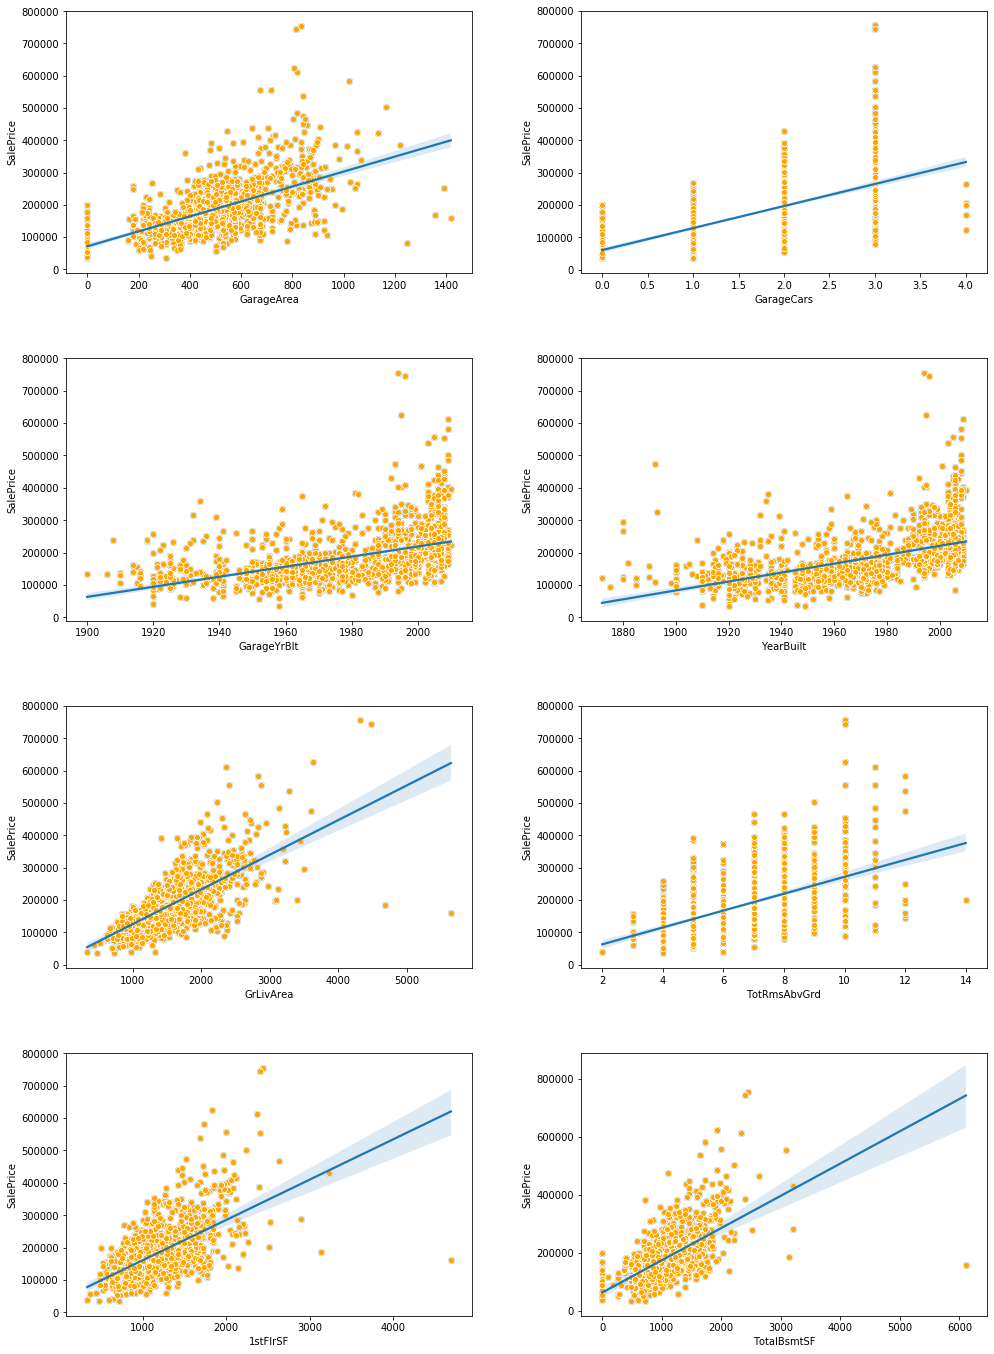

In [16]:
multicoll_pairs=["GarageArea", "GarageCars", "GarageYrBlt", "YearBuilt", "GrLivArea", "TotRmsAbvGrd", "1stFlrSF", "TotalBsmtSF"]
fig, axes = plt.subplots(4,2,figsize=(15,20))

def plot_two(feat, i, j):
    sns.regplot(x=df_num[feat], y=df_num['SalePrice'], ax=axes[i,j])
    sns.scatterplot(y=df_num['SalePrice'], x=df_num[feat], color=('orange'), ax=axes[i,j])
    fig.tight_layout(pad=5.0)
    
for i,feat in enumerate(multicoll_pairs):
    j = i%2
    plot_two(feat, i//2, j)

In [17]:
df_num.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [18]:
df_num

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,366,0,112,0,0,0,0,4,2010,142125


In [19]:
df_num = df_num.drop(columns=["GarageArea", "GarageYrBlt", "TotRmsAbvGrd", "1stFlrSF"])
df_test_num = df_test_num.drop(columns=["GarageArea", "GarageYrBlt", "TotRmsAbvGrd", "1stFlrSF"])

In [20]:
df_num.dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
Fireplaces         int64
GarageCars         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

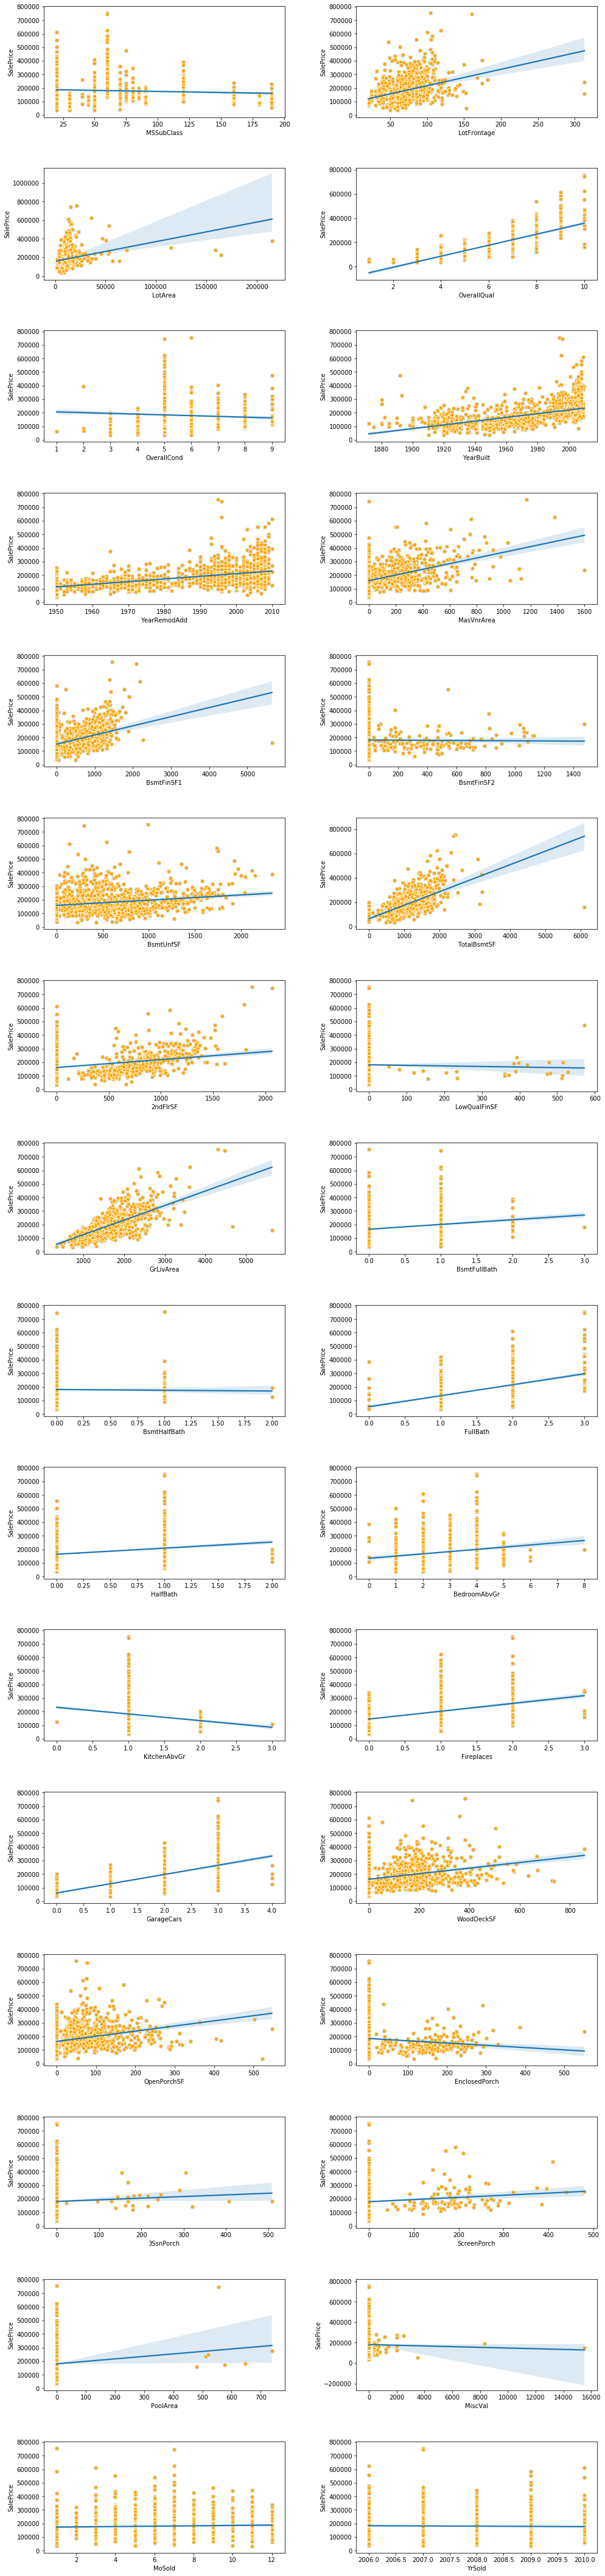

In [21]:
fig, axes = plt.subplots(16,2,figsize=(15,60))
linear_num_cols = df_num.select_dtypes(include='number').columns.tolist()
linear_num_cols.remove('SalePrice')

for i, feat in enumerate(linear_num_cols):
    j = i%2
    plot_two(feat, i//2, j)

In [22]:
nonlinearity_comlumns = ["MSSubClass", "OverallCond", "BsmtFinSF2", "LowQualFinSF", "BsmtFullBath", 
                        "BsmtHalfBath", "HalfBath", "BedroomAbvGr", "MoSold", "YrSold", "PoolArea", "MiscVal"]
drop_col = ["MiscVal", "OverallCond", "LowQualFinSF"]

df_num = df_num.drop(columns=drop_col)
df_test_num = df_test_num.drop(columns=drop_col)

In [23]:
print('Train/Test numeric shapes')
print(df_num.shape)
print(df_test_num.shape)

Train/Test numeric shapes
(1460, 30)
(1459, 29)


In [24]:
df_num = df_num[df_num['LotFrontage'] < 300]
df_num = df_num[df_num['BsmtFinSF1'] < 5000]
df_num = df_num[df_num['TotalBsmtSF'] < 6000]
df_num = df_num[df_num['GrLivArea'] < 4600]
df_num = df_num[df_num['SalePrice'] < 700000]

print(df_num.shape)

(1196, 30)


In [25]:
non_linear_cat_cols = ["BsmtFullBath", "Fireplaces", 
                        "BsmtHalfBath", "HalfBath", "BedroomAbvGr", "MoSold", "YrSold", "PoolArea"]
df_num = df_num.drop(columns=non_linear_cat_cols)
df_test_num = df_test_num.drop(columns=non_linear_cat_cols)



In [26]:
for col in non_linear_cat_cols:
    df_train[col] = df_train[col].astype(object)
    df_test[col] = df_test[col].astype(object)
    
print(df_num.shape)
print(df_test_num.shape)

(1196, 22)
(1459, 21)


In [27]:
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GrLivArea,FullBath,KitchenAbvGr,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,SalePrice
0,60,65.0,8450,7,2003,2003,196.0,706,0,150,...,1710,2,1,2,0,61,0,0,0,208500
1,20,80.0,9600,6,1976,1976,0.0,978,0,284,...,1262,2,1,2,298,0,0,0,0,181500
2,60,68.0,11250,7,2001,2002,162.0,486,0,434,...,1786,2,1,2,0,42,0,0,0,223500
3,70,60.0,9550,7,1915,1970,0.0,216,0,540,...,1717,1,1,3,0,35,272,0,0,140000
4,60,84.0,14260,8,2000,2000,350.0,655,0,490,...,2198,2,1,3,192,84,0,0,0,250000


In [28]:
def missing_cols(df):
    cols = df.columns[df.isna().any()].tolist()
    print("Columns  |  Percentage Missing")
    for column in cols:
        percent = round((sum(df[column].isnull())/df.shape[0])*100,2)
        print(column, ":", percent, "%")

In [29]:
missing_cols(df_num)

Columns  |  Percentage Missing
MasVnrArea : 0.5 %


In [30]:
missing_cols(df_test_num)

Columns  |  Percentage Missing
LotFrontage : 15.56 %
MasVnrArea : 1.03 %
BsmtFinSF1 : 0.07 %
BsmtFinSF2 : 0.07 %
BsmtUnfSF : 0.07 %
TotalBsmtSF : 0.07 %
GarageCars : 0.07 %


In [31]:
target = np.log1p(df_num['SalePrice'])

In [32]:
target

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1196, dtype: float64

In [33]:
def categorical_plot(df, col, xlabel='Values', size=(8,4)):
    y_train = df[col].value_counts().values
    x_train = df[col].value_counts().index.tolist()
    plt.title(col)
    sns.barplot(x_train, y_train)
    plt.xlabel(xlabel)
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('count')
    plt.show()

In [34]:
num_idx = df_num.index.tolist()
cat_cols = df_train.select_dtypes(exclude=[np.number]).columns.tolist()

df_cat = df_train.loc[num_idx][cat_cols]
df_cat_test = df_test[cat_cols]
print('Train/Test categoric shapes')
print(df_cat.shape)
print(df_cat_test.shape)

Train/Test categoric shapes
(1196, 51)
(1459, 51)


In [35]:
missing_cols(df_cat)

Columns  |  Percentage Missing
Alley : 92.81 %
MasVnrType : 0.5 %
BsmtQual : 2.59 %
BsmtCond : 2.59 %
BsmtExposure : 2.68 %
BsmtFinType1 : 2.59 %
BsmtFinType2 : 2.68 %
Electrical : 0.08 %
FireplaceQu : 50.17 %
GarageType : 6.19 %
GarageFinish : 6.19 %
GarageQual : 6.19 %
GarageCond : 6.19 %
PoolQC : 99.67 %
Fence : 81.02 %
MiscFeature : 96.74 %


In [36]:
missing_cols(df_cat_test)

Columns  |  Percentage Missing
MSZoning : 0.27 %
Alley : 92.67 %
Utilities : 0.14 %
Exterior1st : 0.07 %
Exterior2nd : 0.07 %
MasVnrType : 1.1 %
BsmtQual : 3.02 %
BsmtCond : 3.08 %
BsmtExposure : 3.02 %
BsmtFinType1 : 2.88 %
BsmtFinType2 : 2.88 %
BsmtFullBath : 0.14 %
BsmtHalfBath : 0.14 %
KitchenQual : 0.07 %
Functional : 0.14 %
FireplaceQu : 50.03 %
GarageType : 5.21 %
GarageFinish : 5.35 %
GarageQual : 5.35 %
GarageCond : 5.35 %
PoolQC : 99.79 %
Fence : 80.12 %
MiscFeature : 96.5 %
SaleType : 0.07 %


In [37]:
drop_cat_list=['Alley','PoolQC','Fence','MiscFeature']

In [38]:
df_cat = df_cat.drop(columns=drop_cat_list)
df_cat_test = df_cat_test.drop(columns=drop_cat_list)

In [39]:
df_cat.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolArea,MoSold,YrSold,SaleType,SaleCondition
count,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,...,1122,1122,1122,1122,1196,1196,1196,1196,1196,1196
unique,5,2,4,4,1,5,3,25,9,6,...,6,3,5,5,3,5,12,5,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Attchd,Unf,TA,TA,Y,0,7,2009,WD,Normal
freq,917,1191,851,1080,1196,916,1144,185,1035,1184,...,690,505,1059,1077,1090,1192,199,273,1019,959


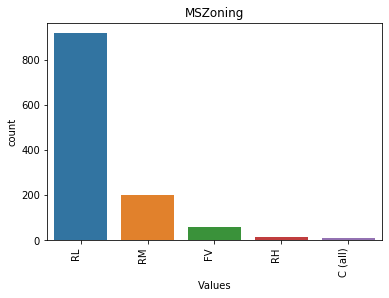

In [40]:
categorical_plot(df_cat,"MSZoning")

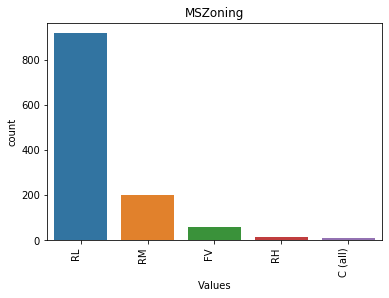

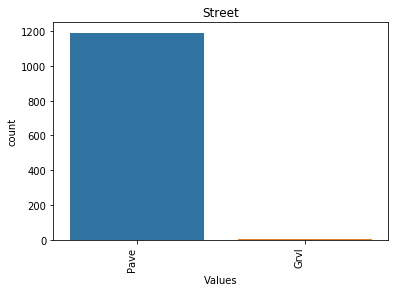

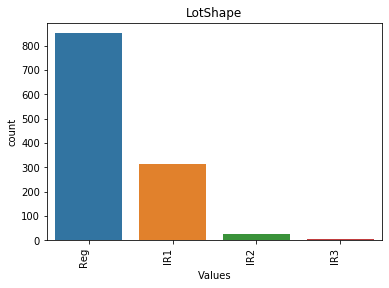

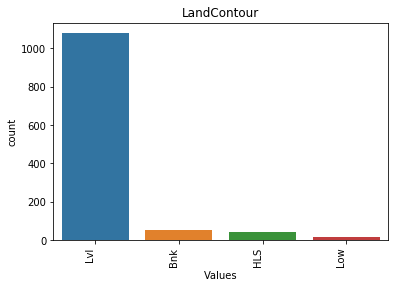

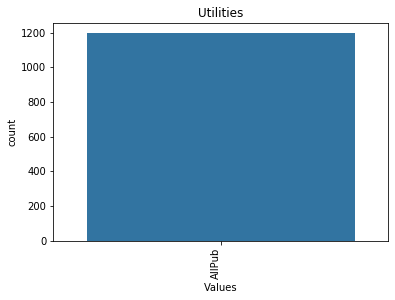

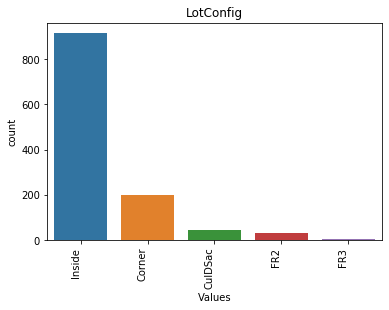

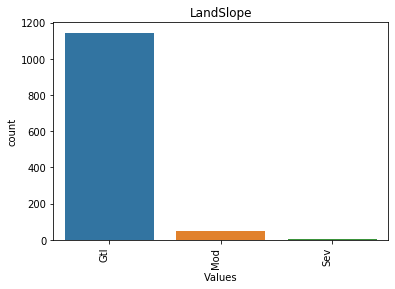

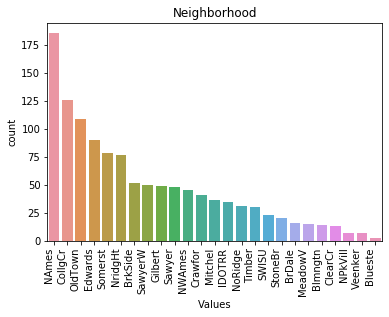

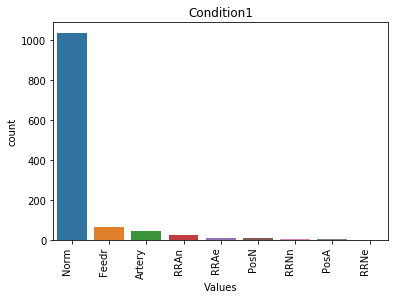

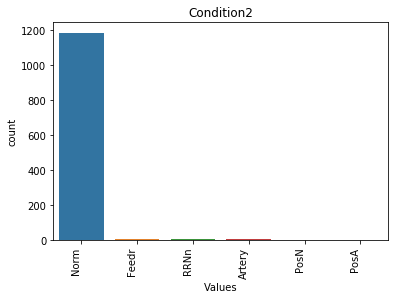

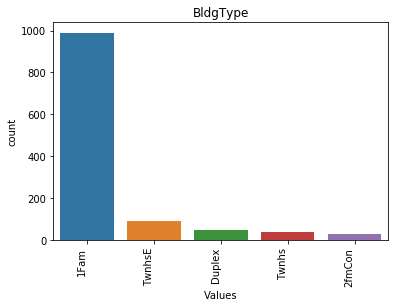

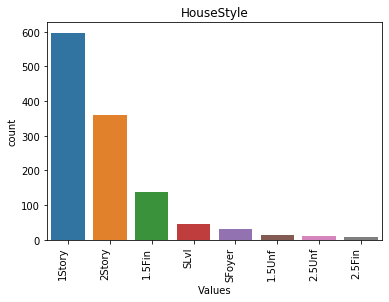

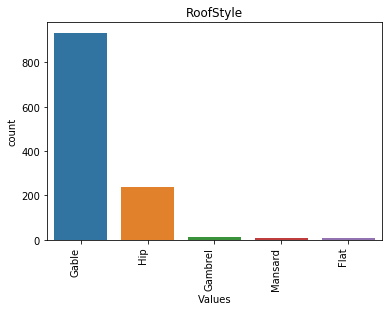

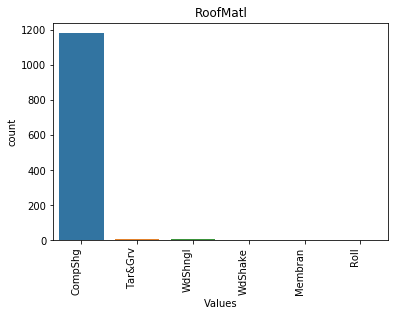

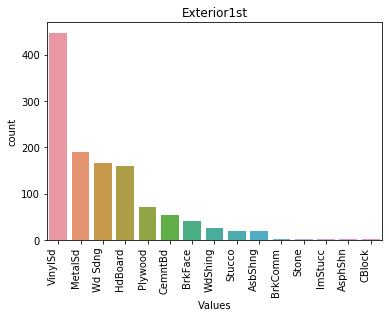

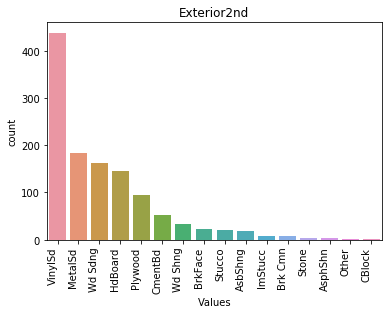

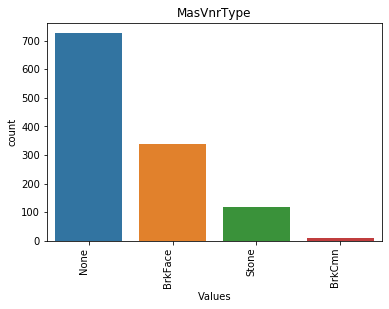

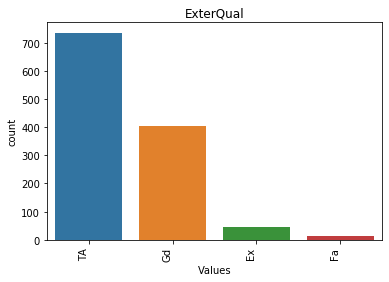

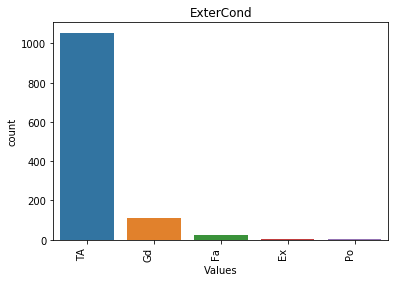

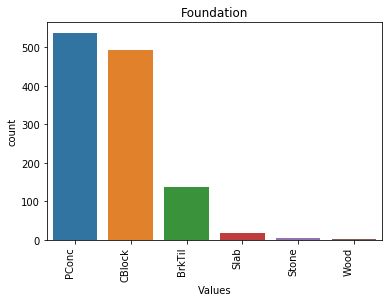

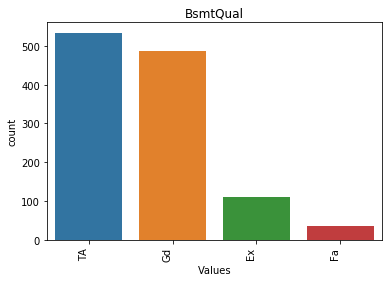

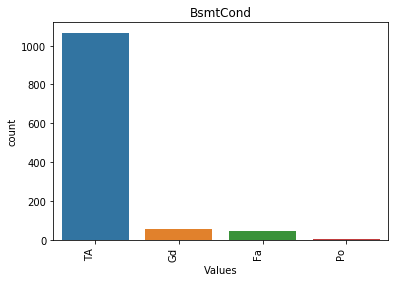

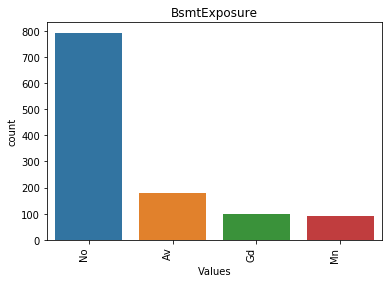

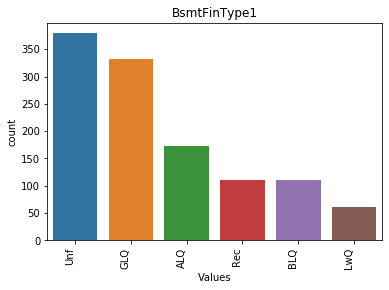

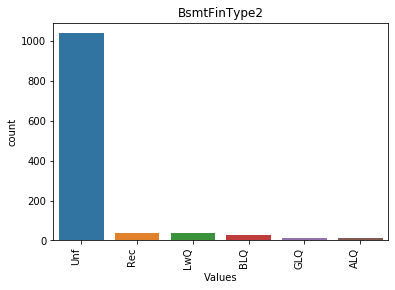

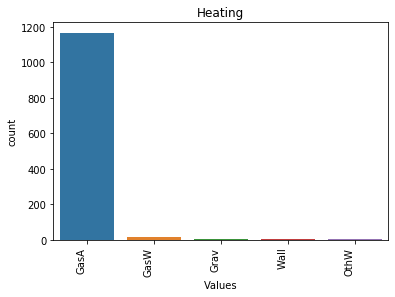

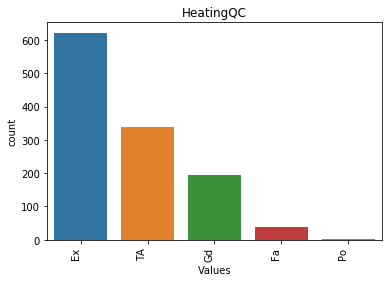

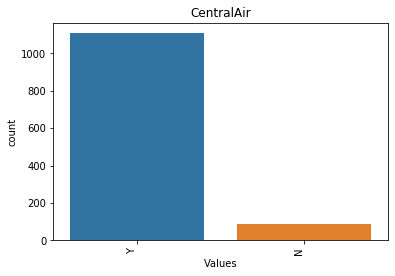

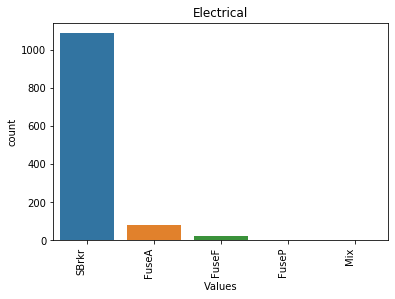

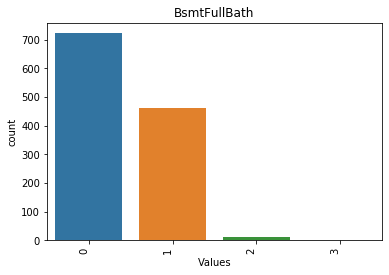

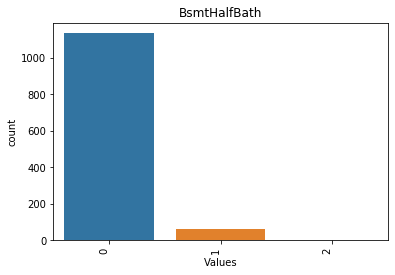

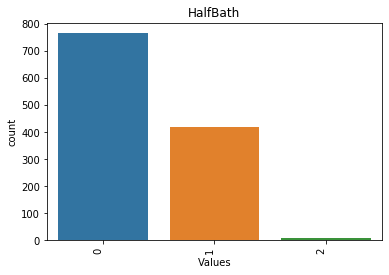

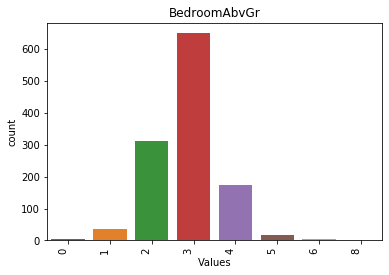

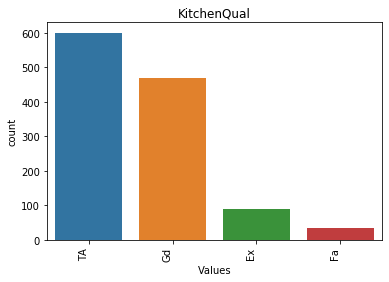

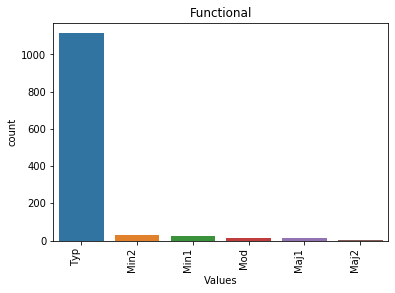

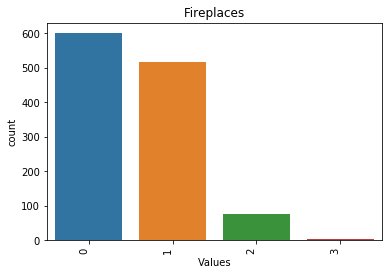

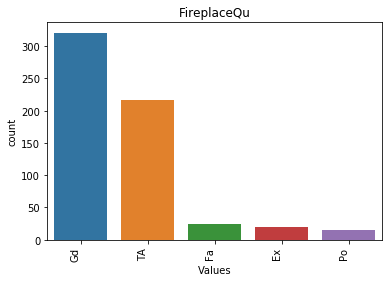

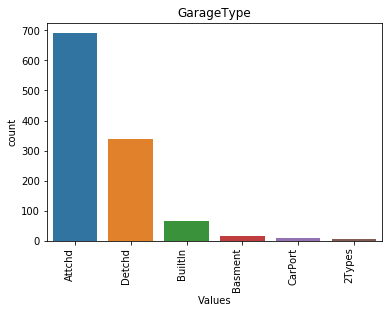

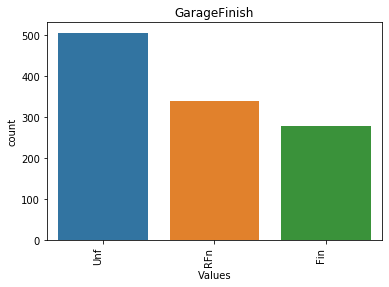

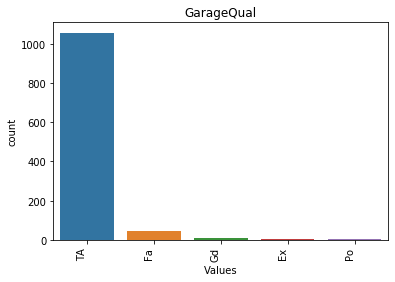

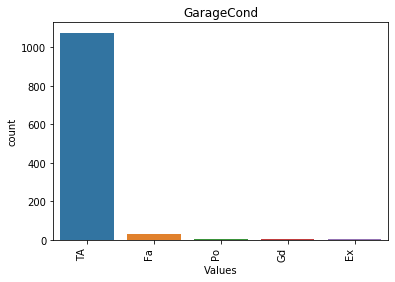

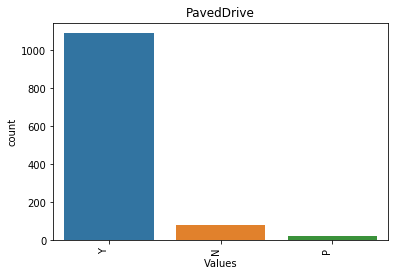

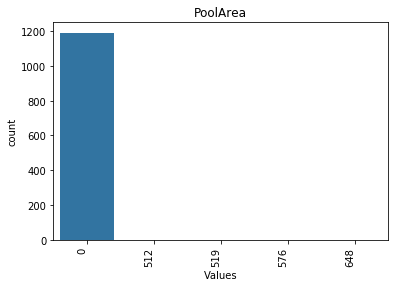

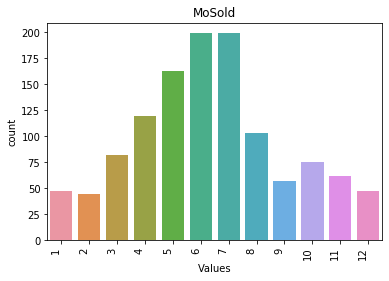

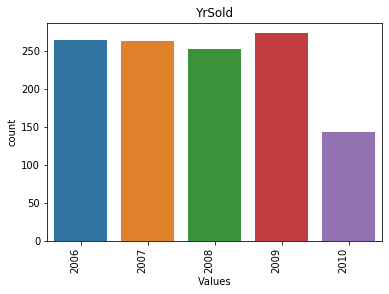

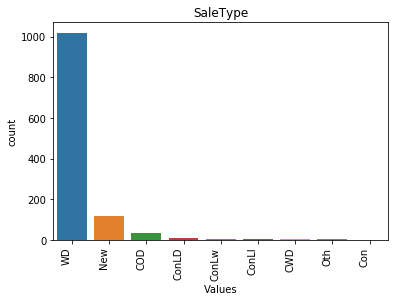

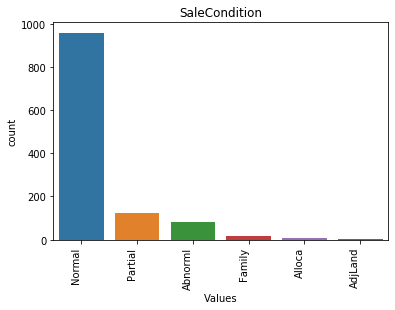

In [41]:
for col in df_cat.keys().to_list():
    categorical_plot(df_cat,col)

In [42]:
modified_cols = ['Street', 'MasVnrType', 'PoolArea', 'RoofMatl']

df_cat = df_cat.drop(columns=['Utilities'])
df_cat_test = df_cat_test.drop(columns=['Utilities'])

df_cat['PoolArea'] = df_cat['PoolArea'].apply(lambda x: 'Y' if x>1 else 'N')
df_cat_test['PoolArea'] = df_cat_test['PoolArea'].apply(lambda x: 'Y' if x>1 else 'N')

df_cat['Street'] = df_cat['Street'].apply(lambda x: 'Pave' if x=='Pave' else 'No Pave')
df_cat_test['Street'] = df_cat_test['Street'].apply(lambda x: 'Pave' if x=='Pave' else 0)

df_cat['MasVnrType'] = df_cat["MasVnrType"].apply(lambda x: 'N' if x=="None" else 'Y')
df_cat_test['MasVnrType'] = df_cat_test["MasVnrType"].apply(lambda x: 'N' if x=="None" else 'Y')

df_cat['RoofMatl'] = df_cat['RoofMatl'].apply(lambda x: 'CompShg' if x=='CompShg' else 'Other')
df_cat_test['RoofMatl'] = df_cat_test['RoofMatl'].apply(lambda x: 'CompShg' if x=='CompShg' else 'Other')


### Concating numeric and categorical features

In [43]:
cat_cols = df_cat.columns.to_list()
num_cols = df_num.columns.to_list()

df_test_num = df_test_num.reset_index(drop=True)
df_num = df_num.reset_index(drop=True)
df_cat = df_cat.reset_index(drop=True)
df_test_cat = df_cat_test.reset_index(drop=True)

final_train = pd.concat([df_num, df_cat], axis=1)
final_test = pd.concat([df_test_num, df_test_cat], axis=1)

print('Final Shapes:')
print(final_train.shape)
print(final_test.shape)

Final Shapes:
(1196, 68)
(1459, 67)


- Apply box-cox transform to features having skewness > 0.5

In [44]:
def sqrt_skew(df):
    
    sk_feats = df.apply(lambda x: stats.skew(x)).sort_values(ascending=False)
    high_skew = sk_feats[abs(sk_feats) > 0.5].index
    for feat in high_skew:
        # df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
        df[feat] = np.sqrt(df[feat])
        
        
    return df

In [45]:
# ncols = num_cols[:-1]
# final_train[ncols] = sqrt_skew(final_train[ncols])
# final_test[ncols] = sqrt_skew(final_test[ncols])

### Train Test Split

In [46]:
Y = target.values
X = final_train

x_test = final_test.copy()
x_train, x_cv, y_train, y_cv = train_test_split(X, Y, train_size=0.7, random_state=100)

print('Train cv data shape')
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

Train cv data shape
(837, 68)
(359, 68)
(1459, 67)


### Missing values in numeric features

In [47]:
# inputing numeric values
# Featurization of numeric data

num_cols_in = df_num.columns.to_list()
num_cols_in.remove('SalePrice')

imputer = SimpleImputer(strategy='median')
# x_train_num에 대해서 결측치 median으로 계산 후 채우기
x_train_num = imputer.fit_transform(x_train[num_cols_in])
# 나머지 데이터들에는 x_train_num에서 계산된 결측치 값과 똑같은 값으로 채워줌
x_cv_num = imputer.transform(x_cv[num_cols_in])
x_test_num = imputer.transform(x_test[num_cols_in])

In [48]:
scaler = RobustScaler()
#위와 같은 방법으로 normalize
x_train_num = scaler.fit_transform(x_train_num)
x_cv_num = scaler.transform(x_cv_num)
x_test_num = scaler.transform(x_test_num)

df_num = pd.DataFrame(x_train_num, columns=num_cols_in)
df_cv_num = pd.DataFrame(x_cv_num, columns=num_cols_in)
df_test_num = pd.DataFrame(x_test_num, columns=num_cols_in)



### Misssing values in categoric features

In [49]:
# cat_cols = df_cat.columns.to_list()

# # missing values in df
# imputer = SimpleImputer(strategy='constant', fill_value='MISSING')
# df_cat = imputer.fit_transform(df_cat[cat_cols])
# df_cat_test = imputer.transform(df_cat_test[cat_cols])

# df_cat = pd.DataFrame(df_cat, columns=cat_cols)
# df_cat_test = pd.DataFrame(df_cat_test, columns=cat_cols)

x_train_cat = x_train[cat_cols]
x_cv_cat = x_cv[cat_cols]
x_test_cat = x_test[cat_cols]

for col in cat_cols:
    val = x_train_cat[col].mode()[0]
    x_train_cat[col] = x_train_cat[col].fillna(val)
    x_cv_cat[col] = x_cv_cat[col].fillna(val)
    x_test_cat[col] = x_test_cat[col].fillna(val)

### Onehot encoding categories 

In [51]:
df_cat_dummy = pd.get_dummies(x_train_cat, columns=cat_cols, drop_first=True)
df_cv_cat_dummy = pd.get_dummies(x_cv_cat, columns=cat_cols, drop_first=True)
df_test_cat_dummy = pd.get_dummies(x_test_cat, columns=cat_cols, drop_first=True)
print(df_cat_dummy.shape)
print(df_cv_cat_dummy.shape)
print(df_test_cat_dummy.shape)



(837, 214)
(359, 199)
(1459, 213)


In [55]:
df_cat, df_cat_cv = df_cat_dummy.align(df_cv_cat_dummy, join='left', axis=1)
df_cat, df_cat_test = df_cat_dummy.align(df_test_cat_dummy, join='left', axis=1)
df_cat_test = df_cat_test.fillna(0)
df_cat_cv = df_cat_cv.fillna(0)

print('dummy categorical data shapes after aligning with train data')
print(df_cat.shape)
print(df_cat_cv.shape)
print(df_cat_test.shape)

dummy categorical data shapes after aligning with train data
(837, 214)
(359, 214)
(1459, 214)


In [56]:
# reseting index
df_cat_dummy = df_cat.reset_index(drop=True)
df_cat_dummy

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
833,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
834,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
835,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [57]:
df_cv_cat_dummy = df_cat_cv.reset_index(drop=True)
df_test_cat_dummy = df_cat_test.reset_index(drop=True)
df_num = df_num.reset_index(drop=True)
df_cv_num = df_cv_num.reset_index(drop=True)
df_test_num = df_test_num.reset_index(drop=True)

final_train = pd.concat([df_num,df_cat_dummy], axis=1)
final_cv = pd.concat([df_cv_num,df_cv_cat_dummy], axis=1)
final_test = pd.concat([df_test_num,df_test_cat_dummy], axis=1)

print('Final shapes:')
print(final_train.shape)
print(final_cv.shape)
print(final_test.shape)

Final shapes:
(837, 235)
(359, 235)
(1459, 235)


# ML Models
### Linear regression

In [58]:
x_train = final_train.copy()
x_cv = final_cv.copy()
x_test = final_cv.copy()

In [60]:
linear = LinearRegression()
linear.fit(x_train, y_train)

y_pred_train = linear.predict(x_train)
y_pred_cv = linear.predict(x_cv)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_cv, y_pred_cv))))
print('R2 score = ' + str(r2_score(y_cv, y_pred_cv)))

Root Mean Square Error train = 0.08644348941763887
Root Mean Square Error test = 0.13733540086599447
R2 score = 0.888627980780453


### Ridge Regression 

In [65]:
ridge = Ridge()
ridge.fit(x_train, y_train)

y_pred_train = ridge.predict(x_train)
y_pred_cv = ridge.predict(x_cv)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_cv, y_pred_cv))))
print('R2 score = ' + str(r2_score(y_cv, y_pred_cv)))

Root Mean Square Error train = 0.08937076131172814
Root Mean Square Error test = 0.12889547091720147
R2 score = 0.9018960690141988


### Lasso Regression 

In [66]:
lasso = Lasso()
lasso.fit(x_train, y_train)

y_pred_train = lasso.predict(x_train)
y_pred_cv = lasso.predict(x_cv)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_cv, y_pred_cv))))
print('R2 score = ' + str(r2_score(y_cv, y_pred_cv)))

Root Mean Square Error train = 0.40406535452179165
Root Mean Square Error test = 0.4005175054554608
R2 score = 0.052772932314007925


### feature selection with lasso

In [68]:
lasso = Lasso(alpha=0.05)
lasso.fit(x_train, y_train)

y_pred_train = lasso.predict(x_train)
y_pred_cv = lasso.predict(x_cv)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_cv, y_pred_cv))))
print('R2 score = ' + str(r2_score(y_cv, y_pred_cv)))

Root Mean Square Error train = 0.1831226120449573
Root Mean Square Error test = 0.18282109740880242
R2 score = 0.802637918101849


Text(0.5, 1.0, 'Coefficients in the Model')

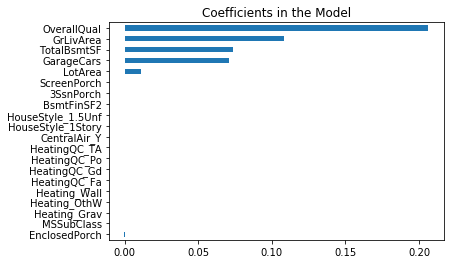

In [70]:
coef = pd.Series(lasso.coef_, index = x_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind='barh')
plt.title("Coefficients in the Model")

### Elsatic net

In [71]:
el = ElasticNet()
el.fit(x_train, y_train)

y_pred_train = el.predict(x_train)
y_pred_cv = el.predict(x_cv)

lasso = Lasso()
lasso.fit(x_train, y_train)

y_pred_train = lasso.predict(x_train)
y_pred_cv = lasso.predict(x_cv)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_cv, y_pred_cv))))
print('R2 score = ' + str(r2_score(y_cv, y_pred_cv)))

Root Mean Square Error train = 0.40406535452179165
Root Mean Square Error test = 0.4005175054554608
R2 score = 0.052772932314007925


### Cross validation on Ridge regression

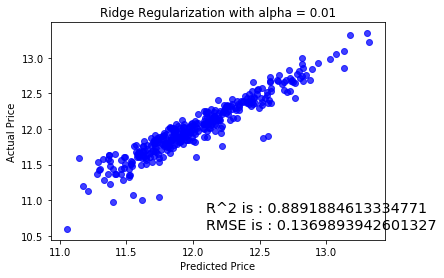

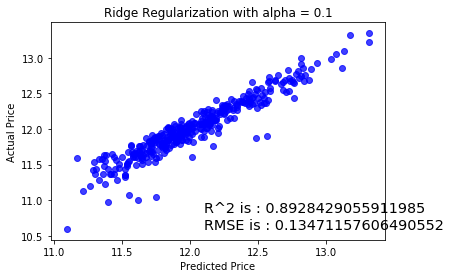

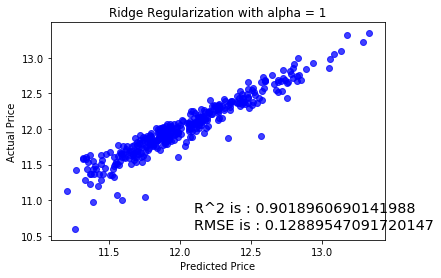

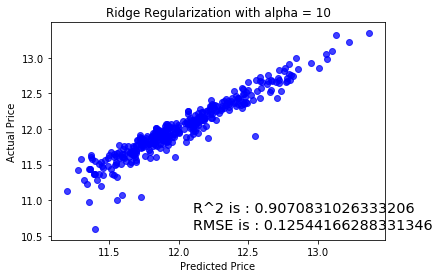

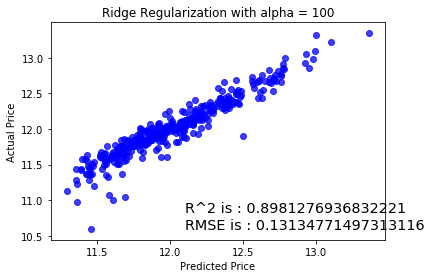

In [72]:
for i in range(-2, 3):
    alpha = 10**i
    rm = Ridge(alpha=alpha)
    ridge_model = rm.fit(x_train, y_train)
    preds_ridge = ridge_model.predict(x_cv)
    
    plt.scatter(preds_ridge, y_cv, alpha=0.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is : {}\nRMSE is : {}'.format(ridge_model.score(x_cv,y_cv),np.sqrt(mean_squared_error(y_cv, preds_ridge)))
    plt.annotate(s=overlay, xy=(12.1,10.6),size='x-large')
    plt.show()